In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
def add_noise(data, noise_factor=0.5):
    noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)
def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)  # Output: (7, 7, 16)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded), Model(input_img, encoded)

In [5]:
autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)

# Predict
decoded_imgs = autoencoder.predict(x_test_noisy)
encoded_imgs = encoder.predict(x_test_noisy)

# Show results
def plot_results(x_noisy, x_original, x_decoded, n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Noisy input
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_noisy[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Original
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_decoded[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 7, 7, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 230ms/step - loss: 0.4079 - val_loss: 0.3132
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 144s 234ms/step - loss: 0.3101 - val_loss: 0.3081
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 226ms/step - loss: 0.3053 - val_loss: 0.3057
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 105s 224ms/step - loss: 0.3029 - val_loss: 0.3040
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 140s 221ms/step - loss: 0.3010 - val_loss: 0.3027
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 103s 221ms/step - loss: 0.2995 - val_loss: 0.3012
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 108s 229ms/step - loss: 0.2988 - val_loss: 0.3007
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 221ms/step - loss: 0.2983 - val_loss: 0.3002
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 225ms/step - loss: 0.2971 - val_loss: 0.2989
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 223ms/step - loss: 0.2964 - val_loss: 0.2987
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


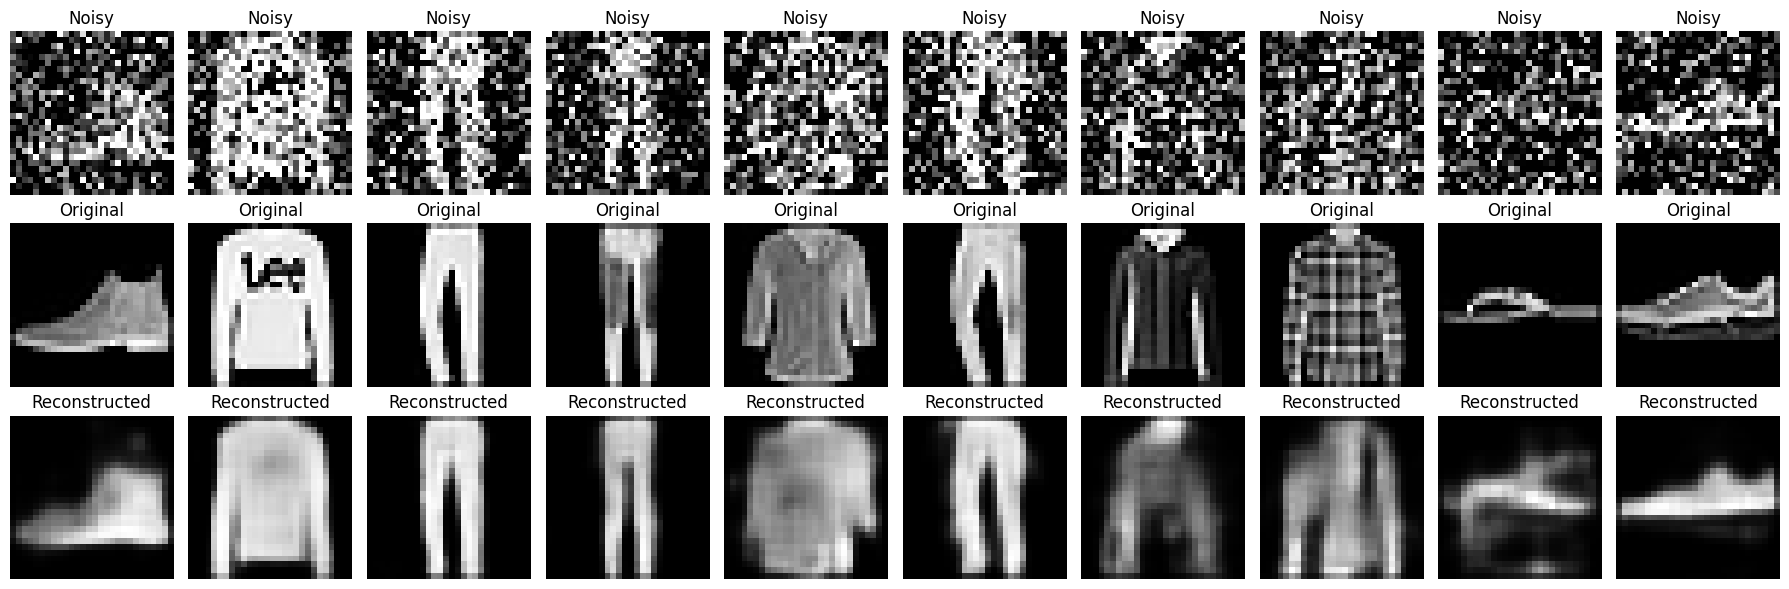

In [6]:
plot_results(x_test_noisy, x_test, decoded_imgs)

In [7]:
def plot_bottleneck(encoded_imgs, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(encoded_imgs[i].reshape(7, 7, 16)[:, :, 0], cmap='viridis')
        plt.title("Bottleneck")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

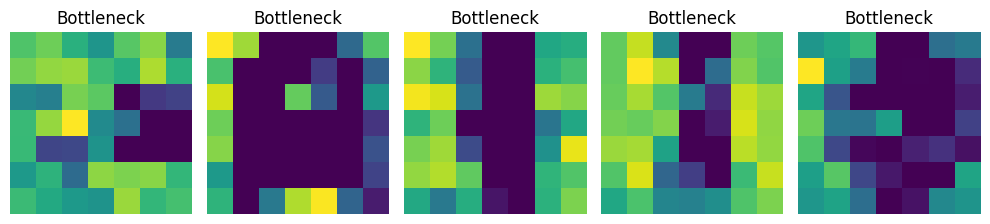

In [8]:
plot_bottleneck(encoded_imgs)


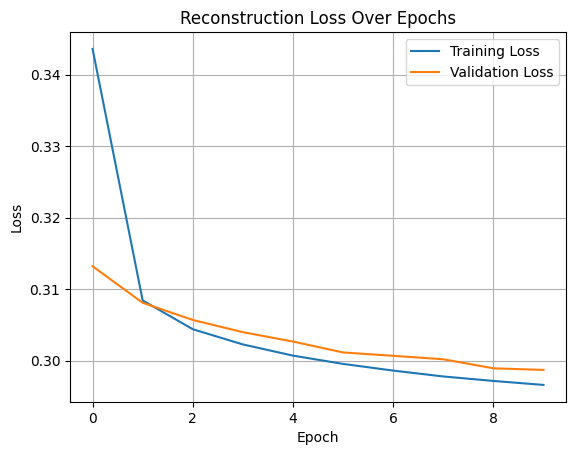

In [9]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Reconstruction Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)